# PID Control

Perhaps the simplest way to control a multirotor is to use successive loop closure. This scheme creates inner and outer PID loops, as shown in the figure. The inner loop controls the attitude and the outer loop controls the position.

Using this scheme assumes gentle flight with small pitch and roll angles.

In [1]:
%%capture
# Load the quadrotor simulator from a previous notebook
%run quadsim.ipynb

In [2]:
def clamp(v, limit):
    return v if np.abs(v) < limit else limit*np.sign(v)
        
class SimplePID:
    def __init__(self, kp, ki, kd, min, max, tau=0.05):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.min = min
        self.max = max
        self.tau = tau

        self.derivative = 0.0
        self.integral = 0.0

        self.last_error = 0.0

    def run(self, error, dt, derivative=None, pclamp=None):

        # P term
        if self.kp:
            # Proportional error clamp, it specified
            e = error if pclamp is None else clamp(error, pclamp)
            p_term = self.kp * e
        else:
            p_term = 0.0

        # D term
        if self.kd:
            if derivative:
                self.derivative = derivative
            elif dt > 0.0001:
                self.derivative = (2.0*self.tau - dt)/(2.0*self.tau + dt)*self.derivative + 2.0/(2.0*self.tau + dt)*(error - self.last_error)
            else:
                self.derivative = 0.0
            d_term = self.kd * self.derivative
        else:
            d_term = 0.0

        # I term
        if self.ki:
            self.integral += (dt/2.0) * (error + self.last_error)
            i_term = self.ki * self.integral
        else:
            i_term = 0.0

        # combine
        u = p_term + d_term + i_term

        # saturate
        if u < self.min:
            u_sat = self.min
        elif u > self.max:
            u_sat = self.max
        else:
            u_sat = u

        # integrator anti-windup
        if self.ki:
            if abs(p_term + d_term) > abs(u_sat):
                # PD is already saturating, so set integrator to 0 but don't let it run backwards
                self.integral = 0
            else:
                # otherwise only let integral term at most take us just up to saturation
                self.integral = (u_sat - p_term - d_term) / self.ki

        # bookkeeping
        self.last_error = error

        return u_sat

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

class PID(Controller):
    """PID Controller
    """
    def __init__(self):
        self.name = "PID"
        
        # estimates of the physical properties of the quadrotor
        self.g = 9.81
        self.mass = 3.81
        Jxx = 0.060224; Jyy = 0.122198; Jzz = 0.132166
        self.I = np.array([[Jxx,0,0],
                           [0,Jyy,0],
                           [0,0,Jzz]])
        
        # Attitude PID controllers
        self.pid_roll = SimplePID(7.63, None, 0.95, -np.pi/6, np.pi/6)
        self.pid_pitch = SimplePID(7.63, None, 1.55, -np.pi/6, np.pi/6)
        self.pid_yaw_rate = SimplePID(2.86, None, None, -np.pi, np.pi)
        
        # Position PID controllers
        self.pid_x = SimplePID(0.028, None, 0.076, -np.pi/12, np.pi/12)
        self.pid_y = SimplePID(0.058, None, 0.11, -np.pi/12, np.pi/12)
        self.pid_z = SimplePID(50.0, None, 23.0, -50, 50)
        self.pid_yaw = SimplePID(1, None, None, -np.pi/8, np.pi/8)
        
        # Compute feed-forward term for thrust
        self.z_ff = self.mass * self.g
               
    def inner(self, commanded, state, Ts):
        
        # flatten the inputs for easy access
        c = commanded.flatten()
        s = state.flatten()
        
        # Force (f) and moments (tau_*)
        f = c[0]
        tph = self.pid_roll.run(c[1]-s[6], Ts)
        tth = self.pid_pitch.run(c[2]-s[7], Ts)
        tps = self.pid_yaw_rate.run(c[3]-s[11], Ts)
        
        return [f, tph, tth, tps]
    
    def outer(self, commanded, state, Ts):
        
        # flatten the inputs for easy access
        c = commanded.flatten()
        s = state.flatten()
        
        th_c = -self.pid_x.run(c[0]-s[0], Ts)
        ph_c = self.pid_y.run(c[1]-s[1], Ts)
        psdot_c = self.pid_yaw.run(c[3]-s[8], Ts)
        
        # Note that because of the way the translational dynamics have
        # been defined, we must rotate the thrust by 180 degrees. The
        # inner term is thrust expressed with z-down. Multiplied by -1
        # the thrust is expressed with z-up.
        thrust_c = -1*(self.pid_z.run(c[2]-s[2], Ts, pclamp=4) - self.z_ff)
        
        return np.array([thrust_c, ph_c, th_c, psdot_c])
    
    def update(self, commanded, state, Ts):

        cmd = commanded[[0,1,2,8]]
        
        #
        # Outer Loop
        #
        
        inner_desired = self.outer(cmd, state, Ts)
        
        #
        # Inner Loop
        #
        
        u = self.inner(inner_desired, state, Ts)
        
        # update the commanded states
        commanded[6] = inner_desired[1]
        commanded[7] = inner_desired[2]
    
        # actuator commands
        return u, commanded

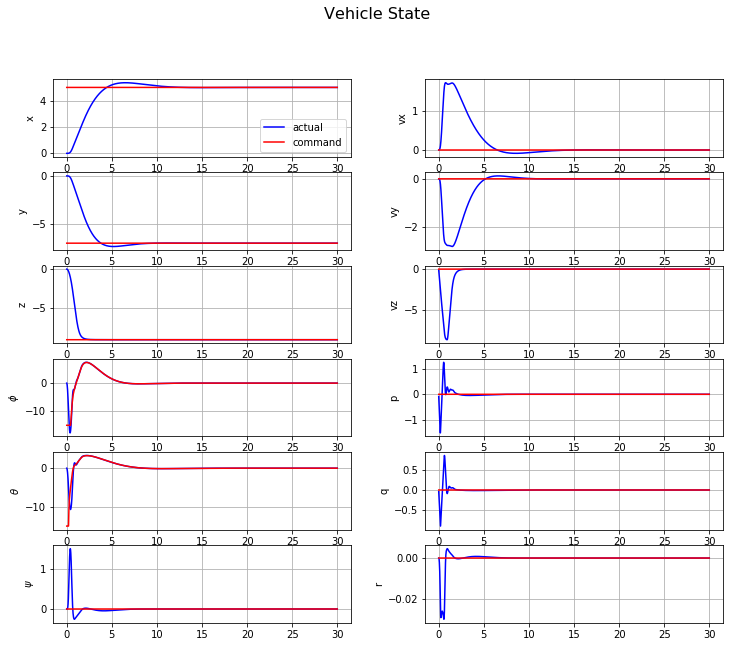

Quadrotor state after 3000 iters:
	r:     [[ 5.000 -7.000 -9.000]].T
	Phi:   [[ 0.000 -0.000  0.000]].T
	v:     [[-0.000  0.000 -0.000]].T
	omega: [[-0.000  0.000 -0.000]].T



In [39]:
# Instantiate a quadrotor model with the given initial conditions
quad = Quadrotor(r=np.array([[0],[0],[0]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0],[0],[0]]))

# Instantiate a simple PID controller
ctrl = PID()

# Setup a setpoint commander
cmdr = Commander(default=True)
cmdr.position(np.array([5, -7, -9]))

# Run the simulation
sim = Simulator(quad, ctrl, cmdr=cmdr)
sim.run(30, Ts=0.01)
sim.plot()

print(sim.quad)